# Visualizing Fire Scars Through False Color Imagery

**Author:** Ixel M.

**Link to Github Repository:** https://github.com/IIDonaji/eds220-hwk4
## About 
In this notebook, we will explore fire scars using false-color imagery derived from remote sensing data. Specifically, we will use Landsat Collection 2 Level-2 atmospherically corrected surface reflectance data, collected by the Landsat 8 satellite, provided in the NetCDF format, along with fire perimter vector data (Shapefile).The analysis centers on four critical technical aspect required for data integration: 
1. Data Harmonization through Coordinate Reference Systsem (CRS) reprojection to align all disparet geospatial layers.
2. Vector-to-Raster Integration, using the fire perimeter shapefile to spatially clip the mutidimensional Landsat NetCDF data. 
3. Mutli_Band Visulaization, focusing on genrating a true-color image (RGB) by selecing and robustly scaling the correct spectral bands from the NetCDF structure. 
4. Geopastail Data Cleaning, which invovle indetifying NaN values to ensure data integrity and resolve plotting errors. 

### About the Data:
**Landsat Collection 2 Level-2** 

Atmospherically corrected surface reflectance data, collected by Landsat 8 satellite. 
Data retrieved from [Microsof Planetary Computer data catalogue](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2) and clipped to an area surroundeding the fire perimeters.For visualization and educational purposes.  

**Dissolved Eaton and Palisades Fire Perimeters**

Features layers are publically avilable from [LA County REST web](https://egis-lacounty.hub.arcgis.com/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about) ArcGIS Hub. Containg heat perimeters for the Palisades and Eaton Fires. 

###
Palisades and Eaton Dissolved Fire Perimeters. (2025). Fire perimeter shapefiles [Geospatial dataset]. ArcGIS Hub. https://hub.arcgis.com/maps/ad51845ea5fb4eb483bc2a7c38b2370c

U.S. Geological Survey. (2025). Landsat 8 Collection 2 Level-2 surface reflectance data [Satellite imagery dataset]. Microsoft Planetary Computer. https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2

# Import Libaries


In [1]:
# Required libaries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import xarray as xr 
import rioxarray

# Import Data

## 2. Fire Perimeter Data Exploration

In [2]:
# Eaton and Palisades fire parmeters shapefiles.
eaton = gpd.read_file(os.path.join("data/eaton_perimeter/Eaton_Perimeter_20250121.shp"))
palisades = gpd.read_file(os.path.join("data/palisades_perimeter/Palisades_Perimeter_20250121.shp"))

In [3]:
# Explore the data
print(f"Eaton Fire Perimeter: {eaton.info()}")
print(f"Palisades Fire Perimeter: {palisades.info()}")

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    20 non-null     int64   
 1   type        20 non-null     object  
 2   Shape__Are  20 non-null     float64 
 3   Shape__Len  20 non-null     float64 
 4   geometry    20 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 932.0+ bytes
Eaton Fire Perimeter: None
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    21 non-null     int64   
 1   type        21 non-null     object  
 2   Shape__Are  21 non-null     float64 
 3   Shape__Len  21 non-null     float64 
 4   geometry    21 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 972.0+ bytes
Palis

In [4]:
# Examin CRS
print('Eaton CRS:', eaton.crs)
print('Palisades CRS:', palisades.crs)

Eaton CRS: EPSG:3857
Palisades CRS: EPSG:3857


Fire Eaton Perimeters: Axes(0.125,0.176658;0.775x0.636684)
Fire Palisades Perimeters: Axes(0.125,0.162856;0.775x0.664288)


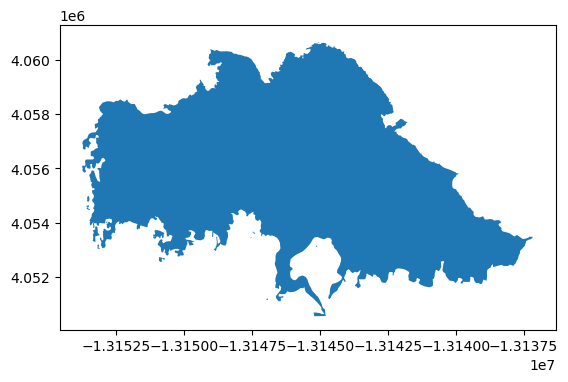

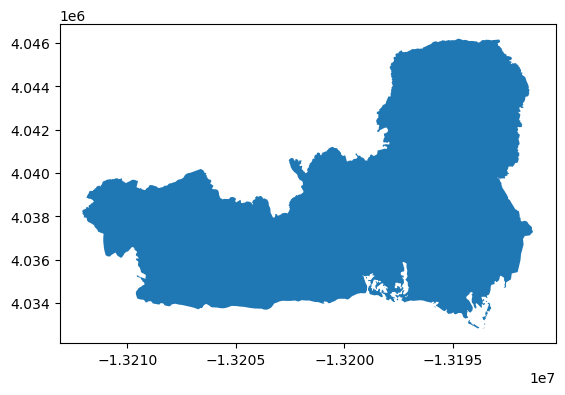

In [5]:
# Plot to validate data quality
print(f"Fire Eaton Perimeters:", eaton.plot())
print(f"Fire Palisades Perimeters:", palisades.plot())

## 3. NetCDF data import and exploration

In [6]:
# Import the Landsat data using xr.open_dataset().
landsat8 = xr.open_dataset("data/landsat8-2025-02-23-palisades-eaton.nc")

In [7]:
# NetCDF quick exploration
print(f"Eaton Fire Perimeter:", landsat8.info)

Eaton Fire Perimeter: <bound method Dataset.info of <xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B ...
Data variables:
    red          (y, x) float32 16MB ...
    green        (y, x) float32 16MB ...
    blue         (y, x) float32 16MB ...
    nir08        (y, x) float32 16MB ...
    swir22       (y, x) float32 16MB ...
    spatial_ref  int64 8B ...>


In [8]:
# Explore dimensions and coordinates
print("Dimensions:", landsat8.dims)
print("\nCoordinates:", list(landsat8.coords))
print("\nData variables:", list(landsat8.data_vars))

Dimensions: FrozenMappingWarningOnValuesAccess({'y': 1418, 'x': 2742})

Coordinates: ['y', 'x', 'time']

Data variables: ['red', 'green', 'blue', 'nir08', 'swir22', 'spatial_ref']


### Summary of Data Exploration:
- For both Eaton Palisades shapefiles the Projected CRS: is EPSG:3857.
  - Each shape file has a comlumn with their geometry and column called type indicating heat perimeter. 
- For the NetCDF xarray.Dataset
  - Dimensions are represented by: 1418 and x 2742
  - The data is a three dimensional with bands: x,y, and time as coordinates
  - 6 data vraibles red, green, blue, nir08, swir22, spatial_ref
  - zero attributes
  - units in meters and crs= EPSG:32611

# 4. Restoring geospatial information

In [9]:
# a. Print CRS with riot.crs accessor.
print('CRS:', landsat8.rio.crs)

CRS: None


The `xarra.Dataset` is not currently geospatial referenced.

In [10]:
# b. Print CRS by acessing the spatial_ref variable.
print(landsat8.spatial_ref.crs_wkt)

PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]


In [11]:
# c. Recover Geospatial infromation write CRS to dataset using rioxarry
landsat8 = landsat8.rio.write_crs(landsat8.spatial_ref.crs_wkt)

In [12]:
# Print CRS of the updated dataset
print( 'CRS after updating', landsat8.rio.crs)

CRS after updating EPSG:32611


# 5. True color image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


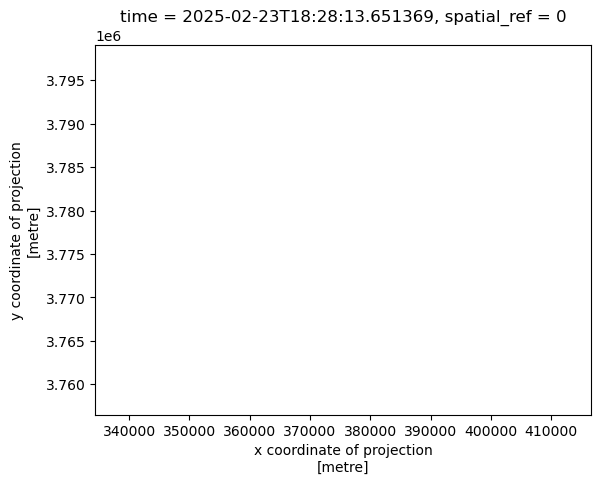

In [13]:
# a. Select RGB variables convert to numpy.array `to_array method and plot RGB image
landsat8[["red", "green", "blue"]].to_array().plot.imshow()

/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


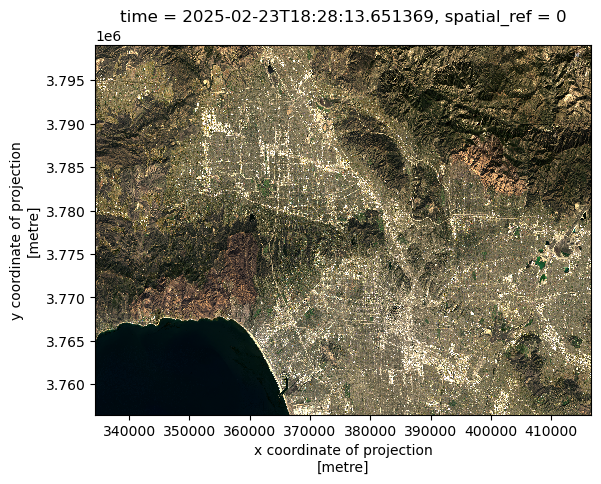

In [14]:
# b. Adjust scale with robust parameter.
landsat8[["red", "green", "blue"]].to_array().plot.imshow(robust= True)

In [15]:
# c. Identify bands with nan Values as a for loop
for bands in ['red','green', 'blue']:
    print(f"{bands}: {landsat8[bands].isnull().any().values}")

red: False
green: True
blue: True


In [16]:
# d. Fill nan values with zero
landsat8 = landsat8.fillna(0)

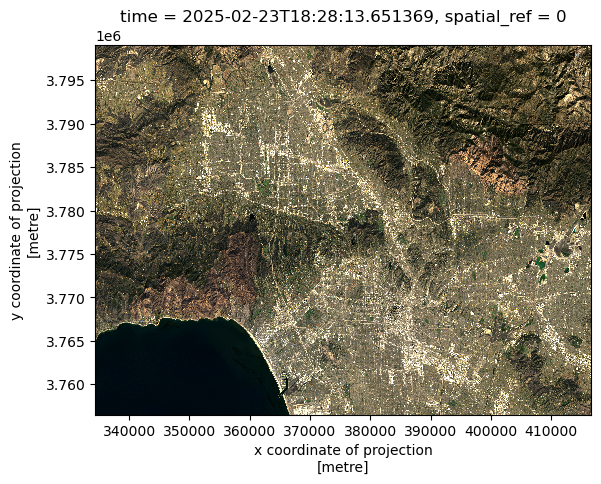

In [17]:
# e. Create new true color image without warnings
landsat8[["red", "green","blue"]].to_array().plot.imshow(robust= True)

### f. Comparing output a. and e.
Part (a) shows a blank image and two warnings due to extreme cloud-reflectance outliers and NaN values. These outliers force Matplotlib to scale most pixels near zero, while NaNs trigger conversion errors. Part (e) fixes these issues: robust=True limits the influence of outliers, and .fillna(0) removes NaN-related warnings, resulting in a clean true-color image.

# 6. False color image

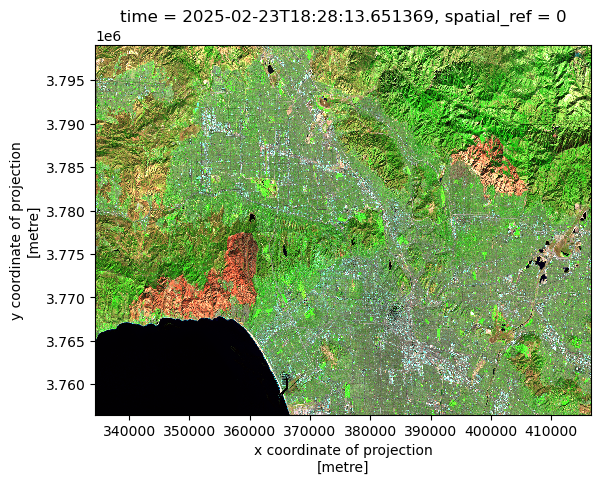

In [18]:
# Select for swir22,nir08, and red variables to create a False color image. 
landsat8[["swir22", "nir08", "red"]].to_array().plot.imshow(robust = True)

# 7. Map

In [19]:
# Examine CRS's Match Landsat
eaton.crs == landsat8.rio.crs
palisades.crs == landsat8.rio.crs

# Reproject fire perimeters to match Landsat CRS
eaton = eaton.to_crs(landsat8.rio.crs)
palisades = palisades.to_crs(landsat8.rio.crs)

# Check Reprojection 
eaton.crs == landsat8.rio.crs
palisades.crs == landsat8.rio.crs

True

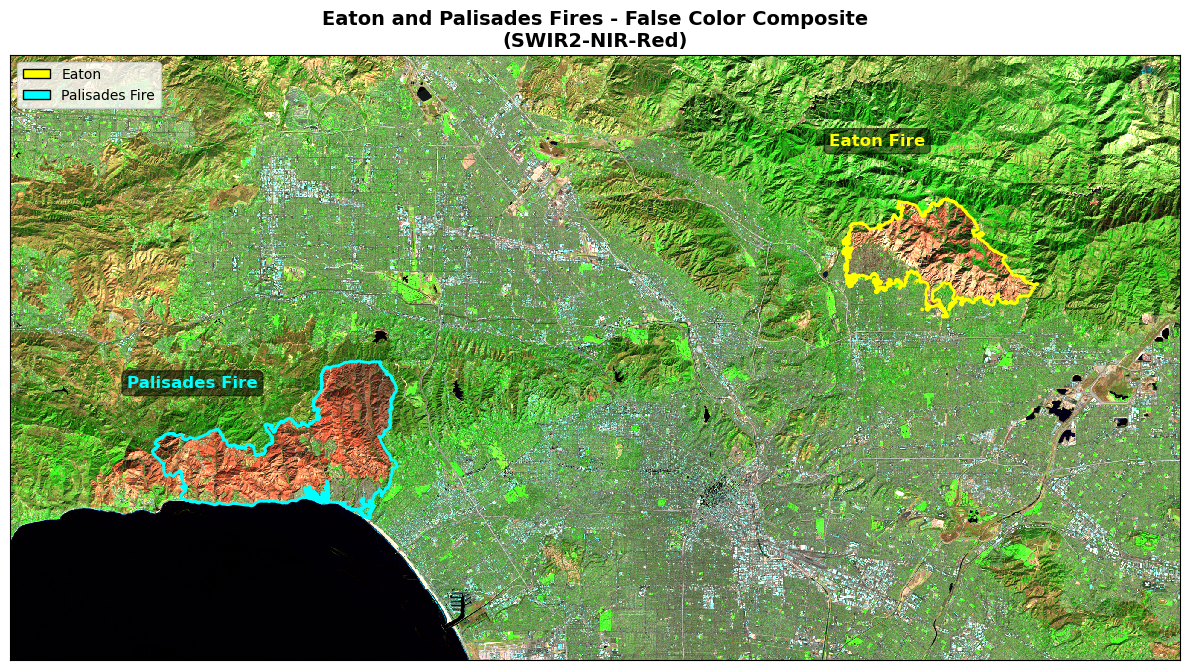

In [20]:
# create figure 
fig, ax = plt.subplots(figsize= (12, 10))

# Plot false color image swir22/nir08/red 
landsat8[["swir22", "nir08", "red"]].to_array().plot.imshow(
ax = ax,
robust= True)

# Plot fire perimeters
eaton.plot(ax=ax, facecolor= 'none', edgecolor= 'yellow', linewidth= 2, label= 'Eaton Fires')
palisades.plot(ax=ax, facecolor= 'none', edgecolor= 'cyan', linewidth= 2, label= 'Palisades Fires')

ax.set_title('Eaton and Palisades Fires - False Color Composite\n(SWIR2-NIR-Red)', 
             fontsize=14, fontweight='bold')
#ax.set_xlabel('Longitude')
#ax.set_ylabel('Latitude')

# Remove axes ticks
ax.set_xticks([])  
ax.set_yticks([])  

# Remove axes labels
ax.set_xlabel("")  
ax.set_ylabel("") 

eaton_patch = mpatches.Patch(facecolor = "yellow", edgecolor = "black", label= "Eaton")
palisades_patch = mpatches.Patch(facecolor = "cyan", edgecolor = "black", label= "Palisades Fire" )
#ax.legend(loc='upper right', fontsize=10)
ax.legend(handles = [eaton_patch, palisades_patch], loc='upper left', fontsize= 10) 

# Add text annotations to identify fires
ax.text(0.70, 0.85, 'Eaton Fire', transform=ax.transAxes, 
        fontsize=12, color='yellow', fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))
ax.text(0.10, 0.45, 'Palisades Fire', transform=ax.transAxes, 
        fontsize=12, color='cyan', fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))

plt.tight_layout()
plt.show()

## Figure Description
The map features a false-color composite created from Landsat 8 data, depicting the regions affected by the Eaton and Palisades Fires. By combining SWIR, NIR, and red spectral bands, the image accentuates differences between healthy vegetation and burned terrain. Areas with intact vegetation appear bright green due to strong NIR reflectance, while fire-damaged zones appear in shades of reddish brown. Yellow and red outlines mark the Eaton and Palisades fire perimeters, clearly showing the extent of each fire. This type of false-color imagery is widely used to assess burn severity and understand how landscapes recover over time.